# Learning objective

This notebook demonstrates the concept of a phase plane for understanding the solution of nonlinear first-order differential equations.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy import fft
from scipy.interpolate import griddata

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# The PDE

The dimenionless KdV equation we derived is
$$
  \dot{W} + WW' + \hat{\delta}^2 W''' = 0,
$$
where $\dot{(~)} = \partial(~)/\partial \bar{\tau}$ and $(~)' = \partial(~)/\partial \bar{\xi}$.

# Reduction to an ODE

We sought a _traveling-wave solution_ of the form $W(\bar{\xi},\bar{\tau})=f(\bar{\xi}-v\bar{\tau})$, where $v$ is the _dimensionless_ speed of the right-traveling wave (in the moving frame!).

This transformation turned the PDE into an ODE:
$$
  -v f' + f f' + \hat{\delta}^2 f''' = 0,
$$
which can also be written as a first-order system:
$$
  \begin{pmatrix} f_0 \\ f_1 \\ f_2 \end{pmatrix}' = \begin{pmatrix} f_1 \\ f_2 \\ \frac{(v - f_0) f_1}{\hat{\delta}^2} \end{pmatrix} .
$$
Primes now denote derivates with respect to the traveling-wave variable $\bar{\xi}-v\bar{\tau}$.

# The phase plane concept

We wish to study solutions of our nonlinear in the $(f',f)$ [phase plane](https://www.youtube.com/watch?v=swt-let4pCI); see [also](https://math.mit.edu/~jorloff/suppnotes/suppnotes03/gs.pdf).


The third-order ODE above can be formally integrated twice:
$$
  \frac{1}{2}\hat{\delta}^2(f')^2 - \frac{v}{2} f^2 + \frac{1}{6} f^3 = c_1 f + c_2 .
$$

What's particularly enticing about this formulation is that phase plane trajectories are [level sets](https://en.wikipedia.org/wiki/Level_set) of a function $H$. In other words, any solution $f$ is such that
$$
  H(f',f) = \frac{\hat{\delta}^2}{2}(f')^2 + \frac{1}{6}f^3 - \frac{v}{2} f^2 - c_1 f = c_2.
$$
This idea is enticing because level sets can be visualized by a [countour plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html), for a range of values of $c_2$ all at once, meaning that **we do not even need to find the solution $f$ to make the phase plane plot!**

Now, we can make a plot of the level sets (solutions in the phase plane) and use sliders to vary the remaining constants, $c_1$ and $v$. We will fix $\hat{\delta} = 1$ without loss of generality because we can just rescale the coordinate $\bar{\xi}-v\bar{\tau} = (\bar{\xi}-v\bar{\tau})/\hat{\delta}$ to eliminate $\hat{\delta}$ from the ODE.

In [2]:
def H(fp,f,c1,v):
  return 1/2*fp**2 + 1/6*f**3 - v/2*f**2 - c1*f

def plot_H(c1,v):
  range = 12
  f = np.linspace(-range,range,num=100)
  fp = np.linspace(-range,range,num=100)
  F, Fp = np.meshgrid(f, fp)

  ax = plt.gca()
  ax.set_ylabel("$f'$")
  #ax.set_ylim(-1,1)
  ax.set_xlabel("$f$")
  #ax.set_xlim(-1,1)
  #ax.set_facecolor('lightgray')

  cont = ax.contour(F, Fp, H(Fp,F,c1,v), 30, cmap='hsv')
  cbar = plt.colorbar(cont)
  cbar.set_label('$c_2$')
  # clearly denote 0 contour (the separatrix)
  ax.contour(F, Fp, H(Fp,F,c1,v),
             levels=[0], colors='black', linestyles='dotted')

  ax.set_aspect('equal', adjustable='box')

  plt.show()

interact(plot_H, c1 = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1),
                 v = widgets.FloatSlider(value=1, min=0, max=4, step=0.1) );

interactive(children=(FloatSlider(value=0.0, description='c1', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

Notice that something "special" happes to the loop near $(0,0)$ when you take $c_1=0$.

# Connection between phase plane level sets and dynamic solutions

Of course, we may wish to plot $f$ as a function of $(\bar{\xi} - \bar{\tau})/\hat{\delta}$. This requires solving the ODE analytically or numerically.

For example:

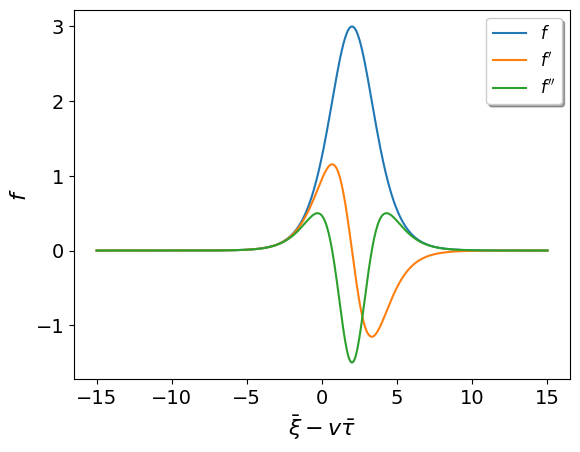

In [3]:
def ode_rhs(xi,f,v):
  return [f[1], f[2], (v - f[0])*f[1]]

f0 = 0.0
c1 = 0.0
c2o = 0.0
v = 1.0

xi = np.linspace(-15,15,num=500)

fsol = solve_ivp(ode_rhs, [xi.min(), xi.max()], [f0, 0, 1e-6], args=(v,),
                 method='DOP853', dense_output=True, rtol=1e-12, atol=1e-12)

fig, ax = plt.subplots()

ax.plot(xi,fsol.sol(xi).T)
ax.set_ylabel("$f$")
ax.set_xlabel(r"$\bar{\xi}-v\bar{\tau}$")

ax.legend(["$f$", "$f'$", "$f''$"], shadow=True);
#ax.set_aspect('equal', adjustable='box')

Or, we may show the phase plane and dynamic trajectories side-by-side. On the phase plane, a black dot indicates the values of $f$ and $f'$ at which the integration on the right starts. Both the initial $f'$ and $f''$ values are found from the $f$, $c_1$ and $c_2$ values chosen on the sliders.

In [ ]:
def fp_func(f,c1,c2,v):
  arg = 2*(c2 - 1/6*f**3 + v/2*f**2 + c1*f)
  return np.sqrt(arg)

def ode_rhs(xi,f,v):
  return [f[1], f[2], (v - f[0])*f[1]]

def plot_H(f0,v,c1,c2):
  range = 12
  f = np.linspace(-range,range,num=100)
  fp = np.linspace(-range,range,num=100)
  F, Fp = np.meshgrid(f, fp)

  fig, ax = plt.subplots(1,2,figsize=(9,4))

  # left panel: phase plane contour plot
  cont = ax[0].contour(F, Fp, H(Fp,F,c1,v), 30, cmap='hsv')
  #cbar = plt.colorbar(cont)
  #cbar.set_label('$c_2$')
  # clearly denote 0 contour (the separatrix)
  ax[0].contour(F, Fp, H(Fp,F,c1,v),
                levels=[0], colors='black', linestyles='dotted')

  # indicate the point for which f() will be found
  rsol = root_scalar(lambda fp : H(fp,f0,c1,v) - c2, x0=0.1,
                     method='secant', xtol=1e-12)
  fp0 = rsol.root
  ax[0].plot(f0, fp0, 'o', color='black')

  ax[0].set_ylabel("$f'$")
  ax[0].set_xlabel("$f$")
  ax[0].set_aspect('equal', adjustable='box')

  # right panel: corresponding f() dynamic solution
  xi = np.linspace(-10,10,num=500)

  fpp0 = c1 + (v - 0.5*f0)*f0

  fsol = solve_ivp(ode_rhs, [xi.min(), xi.max()], [f0, fp0, fpp0], args=(v,),
                   method='DOP853', dense_output=True, rtol=1e-12, atol=1e-12)

  ax[1].plot(xi,fsol.sol(xi)[0],color='black')

  ax[1].set_ylabel("$f$")
  ax[1].set_xlabel(r"$\bar{\xi}-v\bar{\tau}$")
  #ax[1].set_aspect('equal', adjustable='box')
  ax[1].set_box_aspect(1)

  plt.tight_layout()
  plt.show()

interact(plot_H, f0 = widgets.FloatSlider(value=0.1, min=-1, max=5, step=0.1),
                 v = widgets.FloatSlider(value=1, min=0, max=4, step=0.1),
                 c1 = widgets.FloatSlider(value=0, min=0, max=5, step=0.1),
                 c2 = widgets.FloatSlider(value=0, min=-50, max=50, step=5) );

interactive(children=(FloatSlider(value=0.1, description='f0', max=5.0, min=-1.0), FloatSlider(value=1.0, desc…

For initial points inside the separatrix loop (dotted black), we have periodic solutions (bounded). All others diverge to $\infty$ (unbounded). For the special case when the loop stiches through $(0,0)$, we have a solitary wave.